# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
survey_and_sat = survey_fields + ['sat_score']
print(survey_and_sat)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11', 'sat_score']


In [12]:
survey_corr = combined[survey_and_sat].corr()
survey_corr = survey_corr['sat_score']
survey_corr

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
sat_score     1.000000
Name: sat_score, dtype: float64

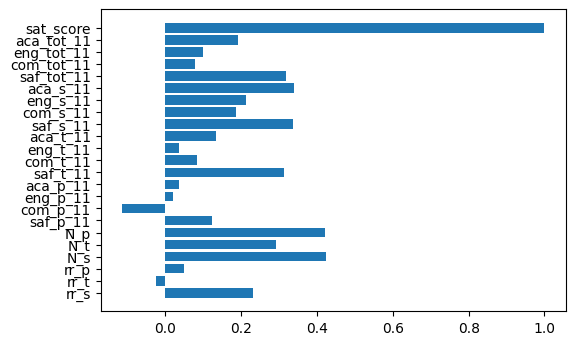

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.barh(survey_and_sat, survey_corr)
plt.show()

`N_p` and `N_s`, the number of parent and student respondents to the survey, respectively, both have relatively high correlations (>0.4). The only two negative correlations are `com_p_11` (communication score based on parents' responses) and `rr_t` (teacher response rate), although the latter is very close to 0. Other relatively high correlations (>=0.3) are `aca_s_11` (academic expectations score based on student responses), `saf_s_11` ( safety and respect score based on students' responses), `saf_t_11` (safety and respect score based on teachers' responses), `N_t` (number of teacher respondents), `saf_tot_11` (safety and respect total score, based on student, teacher, and parent responses).       

# Investigating safety scores

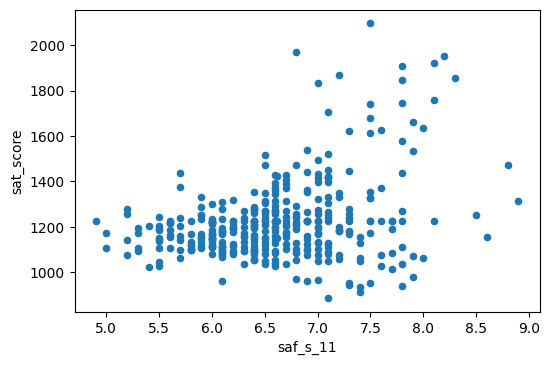

In [14]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.show()

There isn't a clear linear relationship between student's safety scores and SAT scores, but there is an upward trend, especially with safety scores higher than 7. 

# Safety scores by borough

In [15]:
combined['boro'].head()

0    Manhattan
1    Manhattan
2    Manhattan
3    Manhattan
4    Manhattan
Name: boro, dtype: object

In [16]:
boro_safety = combined.groupby("boro").agg(numpy.mean)
boro_safety

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
boro,,,,,,,,,,,,,,,,,,,,,
Bronx,384.050714,393.891831,379.655657,1157.598203,96.473842,149.445409,135.694086,136.857093,9.548387,123.113090,...,12.0,12.0,10461.408602,549.569892,1.344086,0.0,0.0,0.0,40.845473,-73.890973
Brooklyn,391.336947,404.612644,385.414869,1181.364461,131.645682,202.857765,164.940094,183.870968,18.000000,168.902227,...,12.0,12.0,11216.150943,751.556604,1.971698,0.0,0.0,0.0,40.665555,-73.947829
Manhattan,421.070149,437.824710,419.436551,1278.331410,126.135363,192.661966,153.337778,155.421505,2.900000,143.512969,...,12.0,12.0,10024.744444,633.588889,1.433333,0.0,0.0,0.0,40.766244,-73.975350
Queens,422.274953,448.207556,416.270522,1286.753032,160.463942,238.014423,153.975000,307.208165,26.906250,254.299343,...,12.0,12.0,11343.000000,1187.187500,2.390625,0.0,0.0,0.0,40.715715,-73.836422
Staten Island,457.500000,472.500000,452.500000,1382.500000,228.908654,355.111538,194.435000,450.787097,31.000000,380.528319,...,12.0,12.0,10307.100000,1847.500000,5.000000,0.0,0.0,0.0,40.595680,-74.125726


In [17]:
safety_cols = ['saf_p_11', 'saf_t_11', 'saf_s_11', 'saf_tot_11']
boro_safety = boro_safety[safety_cols]
boro_safety

,saf_p_11,saf_t_11,saf_s_11,saf_tot_11
boro,,,,
Bronx,8.346237,7.026882,6.606577,7.322581
Brooklyn,8.036792,6.985849,6.370755,7.129245
Manhattan,8.288889,7.287778,6.831370,7.473333
Queens,8.098437,7.365625,6.721875,7.387500
Staten Island,7.800000,7.210000,6.530000,7.200000


The average total safety score is highest in Manhattan and lowest in Brooklyn. Parents give the highest average safety score to the Bronx, and the lowest to Staten Island. Teachers rate Queens as the safest and Brooklyn as the least safe. Students give the highest average safety score to Manhattan, and the lowest to Brooklyn. In general, parents rate Boroughs as safer than either students or teachers (on average, at least one point higher than student's scores). Students give the lowest safety scores of the three groups. Teachers and students agree that Manhattan and Queens are safer and Brooklyn is less safe. 

# Racial differences in SAT scores

In [18]:
race_sat_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']
race_corr = combined[race_sat_cols].corr()
race_corr = race_corr['sat_score']
race_corr

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
sat_score       1.000000
Name: sat_score, dtype: float64

There are positive correlations with SAT scores and the percentage of white students (0.62) and asian students (0.57). There are negative correlations between SAT scores and the percentage of black (-0.28) and hispanic (-0.4) students. 

## SAT scores and percent of Hispanic students

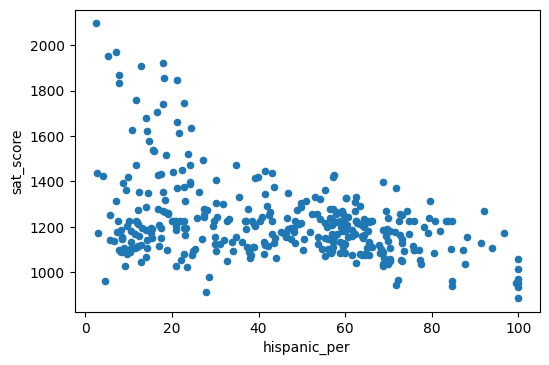

In [19]:
combined.plot.scatter('hispanic_per', 'sat_score')
plt.show()

The scatterplot of the percentage of hispanic students and SAT scores shows that low SAT scores occur at all rates of hispanic student enrollment. However, high SAT scores are from schools with a low percentage of hispanic students. Schools with a high percentage of hispanic students have no high scores. 

Next, I will look at schools with `hispanic_per` greater than `95%`. 

In [20]:
schools_95hispanic = combined['SCHOOL NAME'][combined['hispanic_per'] > 95]
print(schools_95hispanic)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The majority of these school have student populations that  are over 90% economically disadvantaged. 

# Gender and SAT scores

In [21]:
gender_sat_cols = ['male_per', 'female_per', 'sat_score']
gender_corr = combined[gender_sat_cols].corr()
gender_corr = gender_corr['sat_score']
gender_corr[0:2]

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

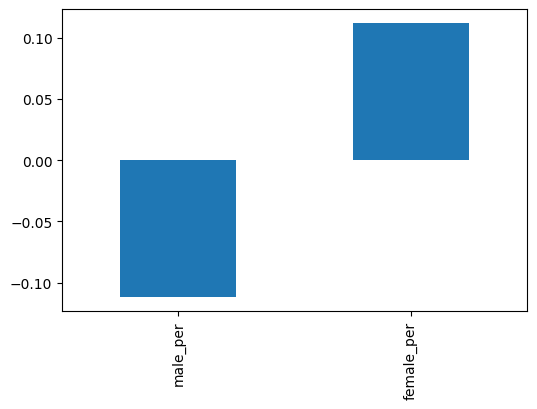

In [22]:
gender_corr[0:2].plot.bar()
plt.show()

A higher percentage of male students is associated with a lower score, while a higher percentage of female students is associated with a higher SAT score. The correlations are relatively small (<|12|). 

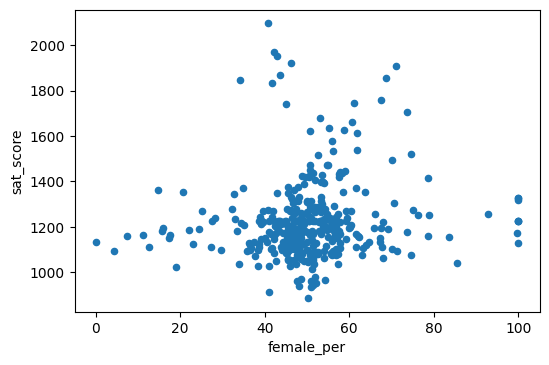

In [23]:
combined.plot.scatter('female_per', 'sat_score')
plt.show()

The majority of the points are clustered around 40-60% female and average scores, which makes sense, as most schools have an approximately equal gender split. There is a spike of high-scoring schools around 40% female, and another between 60-80% female schools. The few schools with 100% female populations have median scores. 

In [24]:
combined_female60 = combined[combined['female_per']>60]
schools_female60_score1700 = combined_female60['SCHOOL NAME'][combined_female60['sat_score']>1700]
schools_female60_score1700

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The Fiorello H. LaGuardia High School of Music & Art and Performing Arts is one of nine specialized public high schools in New York, and requires a portfolio or audition for admission. Bard High School Early College is a private high school and two-year college program. Townsend Harris High School is a magnet high school, also selective. The others are high-performing public schools. 

# Exploring AP Scores vs. SAT Scores

Calculate the percentage of students in each school that took an AP exam

In [25]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

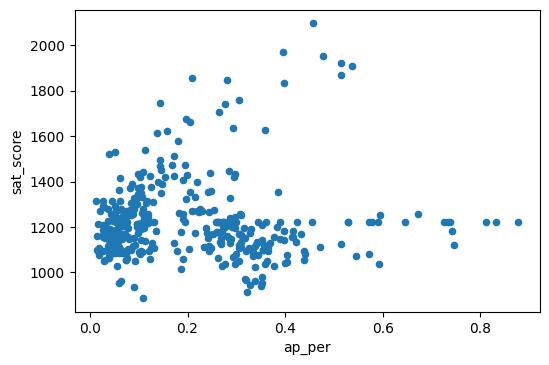

In [26]:
combined.plot.scatter('ap_per', 'sat_score')
plt.show()

There is no clear linear relationship. There is a main cluster of points around average SAT scores and 5% AP test takers, and another around 30-40% test takers. The schools with the highest percentage of AP test-takers perform averagely on the SAT. 

# Class size and SAT scores

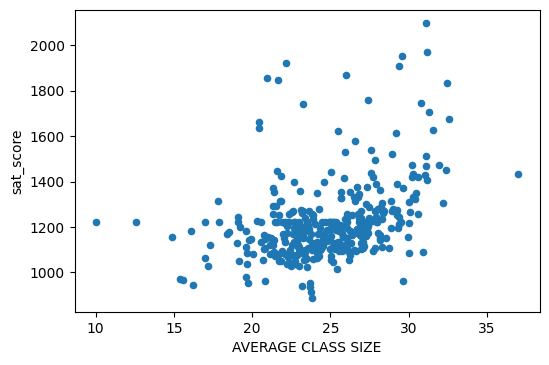

In [27]:
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')
plt.show()

There appears to be a slight positive correlation between class size and SAT scores.

In [31]:
classsize_corr = combined[['sat_score', 'AVERAGE CLASS SIZE']].corr()
classsize_corr = classsize_corr['sat_score']
classsize_corr

sat_score             1.000000
AVERAGE CLASS SIZE    0.381014
Name: sat_score, dtype: float64

There is a 0.38 correlation between class size and SAT scores. One might expect smaller classes to perform better on the SAT, with more attention from teachers. In large classes, it may be more likely for a couple high-scoring students to drag the average up. 